In [1]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
import torch
from torch.utils.data import Dataset,DataLoader
import pandas as pd
import numpy as np

In [2]:
dataset = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))
data = dataset["data"]
label = dataset["target"]
label_names = dataset["target_names"]

In [3]:
class News20Dataset(Dataset):
    def __init__(self,tokenizer=None,max_length=256,transforms=None):
        self.raw_dataset = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))
        self.data = self.raw_dataset["data"]
        self.label = self.raw_dataset["target"]
        self.label_name = self.raw_dataset["target_names"]
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        text = self.data[idx]
        encode_text = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        return encode_text,text,self.label[idx]

In [4]:
embeddings = np.load('embeddings/jina-embeddings-v2-small-en.npy')

In [5]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import umap
from utils.evalUtils import *


In [6]:
tsne = TSNE(n_components=2, perplexity=5, learning_rate=500, n_iter=3000, early_exaggeration=15, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)
# pca = PCA(n_components=2)
# embeddings_2d = pca.fit_transform(embeddings)

## Baseline-Kmeans

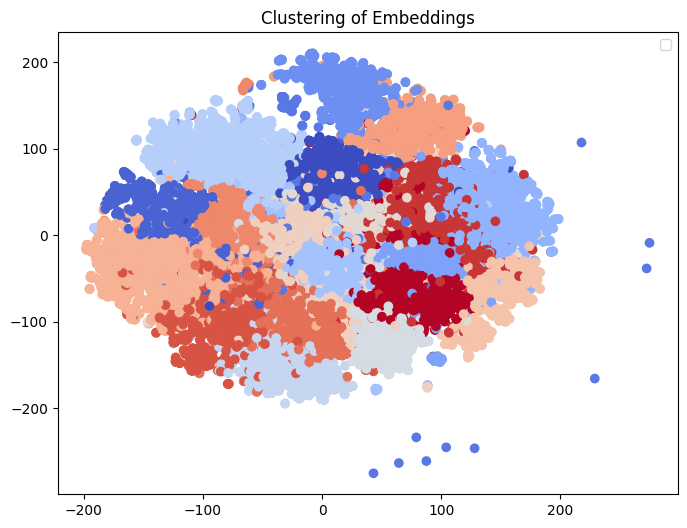

In [49]:
# dbscan = DBSCAN(eps=1, min_samples=5, metric='euclidean')
# pred_labels = dbscan.fit_predict(embeddings)

# reduce dimension 
reducer = umap.UMAP(n_components=16, random_state=42)
embeddings_reduced = reducer.fit_transform(embeddings)
# cluster
kmeans = KMeans(n_clusters=20, random_state=30)
kmeans.fit(embeddings_reduced)
pred_labels = kmeans.predict(embeddings_reduced)
# visualization
plt.figure(figsize=(8, 6))
unique_labels = np.unique(pred_labels)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],c=pred_labels,cmap='coolwarm')
plt.title('Clustering of Embeddings')
plt.legend()
plt.show()

In [51]:
evaluate_ari(label,pred_labels)
evaluate_nmi(label,pred_labels)
evaluate_silhouette(embeddings,pred_labels)

Adjusted Rand Index (ARI): 0.4393
Normalized Mutual Information (NMI): 0.5728
Silhouette Score: 0.0244


np.float32(0.024384663)

## Proposed-Louvain Cluster

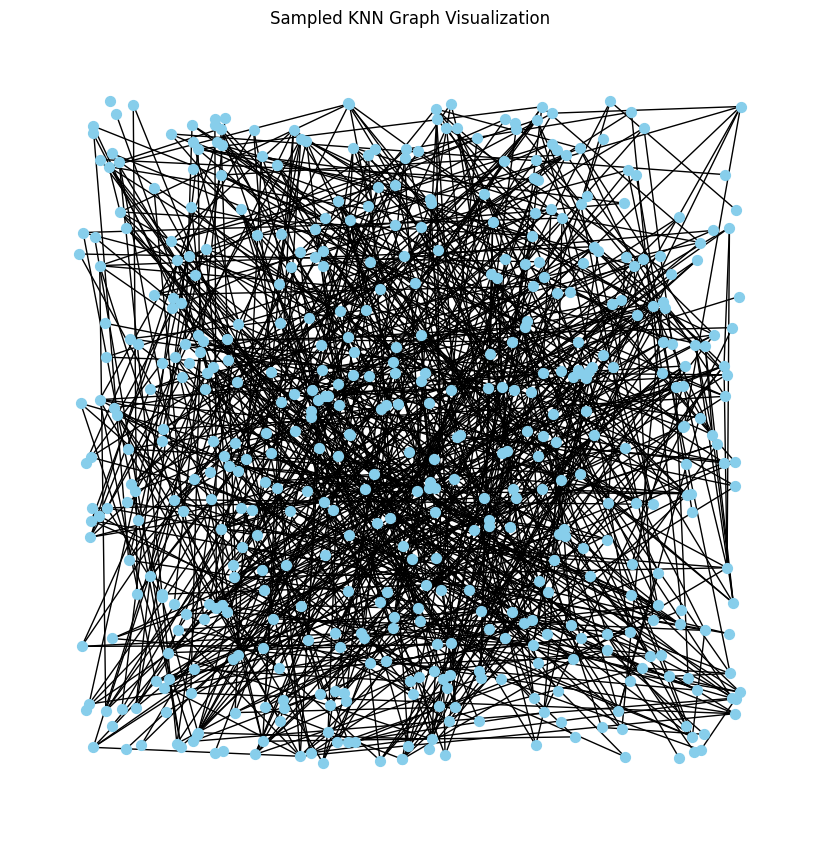

In [75]:
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import random


reducer = umap.UMAP(n_components=256, random_state=42)
embeddings_reduced = reducer.fit_transform(embeddings)
knn = NearestNeighbors(n_neighbors=100)
knn.fit(embeddings_reduced)


adj_matrix = knn.kneighbors_graph(embeddings_reduced).toarray()
adj_matrix = adj_matrix-np.eye(adj_matrix.shape[0])
G = nx.from_numpy_array(adj_matrix)

nodes_list = list(G.nodes())
nodes_sampled = random.sample(nodes_list, 500)

G_sampled = G.subgraph(nodes_sampled)

plt.figure(figsize=(8, 8))
pos = nx.random_layout(G_sampled) 

nx.draw(G_sampled, pos, node_color='skyblue', node_size=50, with_labels=False)
plt.title("Sampled KNN Graph Visualization")
plt.show()


In [76]:
from sklearn.cluster import SpectralClustering
import community as community_louvain

partition = community_louvain.best_partition(G)
pred_labels = list(partition.values())
pred_labels=np.array(pred_labels)


# plt.figure(figsize=(8, 8))
# nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=300)
# nx.draw_networkx_edges(G, pos, alpha=0.5)
# plt.title("Spectral Graph Clustering")
# plt.show()

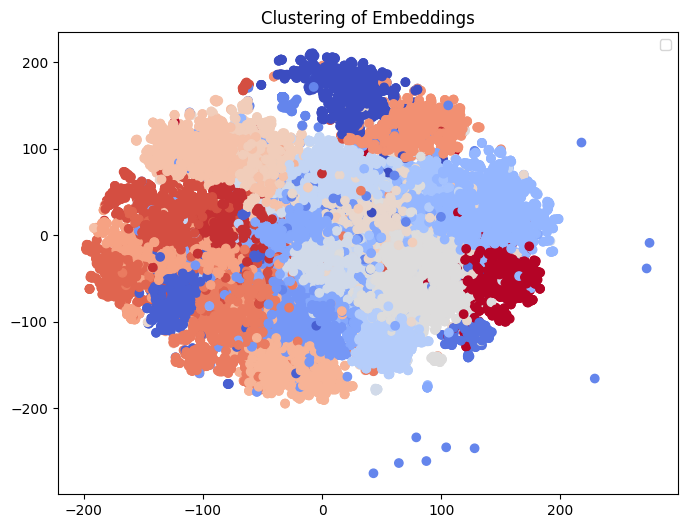

Adjusted Rand Index (ARI): 0.4239
Normalized Mutual Information (NMI): 0.5674
Silhouette Score: 0.0260


np.float32(0.026040029)

In [77]:
# reduce dimension 

# dbscan = DBSCAN(eps=1, min_samples=5, metric='euclidean')
# pred_labels = dbscan.fit_predict(embeddings)
plt.figure(figsize=(8, 6))
unique_labels = np.unique(pred_labels)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],c=pred_labels,cmap='coolwarm')
plt.title('Clustering of Embeddings')
plt.legend()
plt.show()
evaluate_ari(label,pred_labels)
evaluate_nmi(label,pred_labels)
evaluate_silhouette(embeddings,pred_labels)

## Proposed-Girvan-Newman

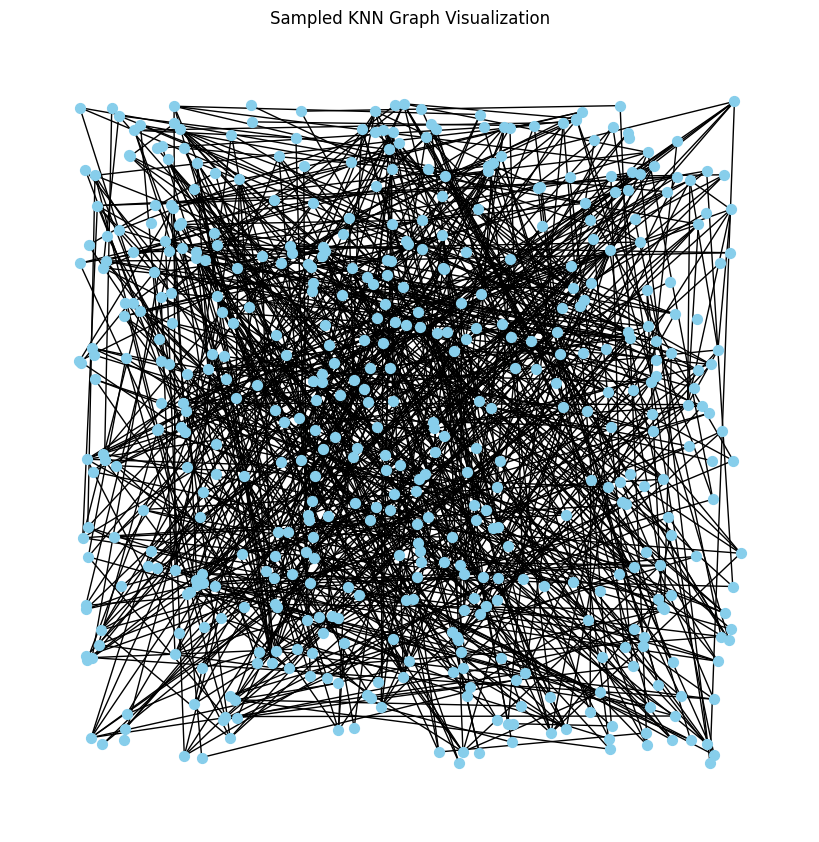

In [7]:
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import random


reducer = umap.UMAP(n_components=256, random_state=42)
embeddings_reduced = reducer.fit_transform(embeddings)
knn = NearestNeighbors(n_neighbors=100)
knn.fit(embeddings_reduced)


adj_matrix = knn.kneighbors_graph(embeddings_reduced).toarray()
adj_matrix = adj_matrix-np.eye(adj_matrix.shape[0])
G = nx.from_numpy_array(adj_matrix)

nodes_list = list(G.nodes())
nodes_sampled = random.sample(nodes_list, 500)

G_sampled = G.subgraph(nodes_sampled)

plt.figure(figsize=(8, 8))
pos = nx.random_layout(G_sampled) 

nx.draw(G_sampled, pos, node_color='skyblue', node_size=50, with_labels=False)
plt.title("Sampled KNN Graph Visualization")
plt.show()


In [ ]:
from networkx.algorithms.community import girvan_newman
communities_generator = girvan_newman(G)

desired_communities = 20
current_communities = next(communities_generator)

for communities in communities_generator:
    current_communities = communities
    if len(current_communities) == desired_communities:
        break
for i, community in enumerate(current_communities):
    print(f"Community {i+1}: {sorted(community)}")